In [1]:
!pip install obspy

In [2]:
!git clone https://github.com/sachalapins/DAS-N2N.git

Cloning into 'DAS-N2N'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 118 (delta 16), reused 0 (delta 0), pack-reused 69 (from 1)
Receiving objects: 100% (118/118), 61.75 MiB | 8.51 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [1]:
!pip install tensorflow==2.15.0

In [2]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [3]:
import tensorflow as tf # version 2
from tensorflow import keras

In [4]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import losses

from skimage.util import view_as_blocks, view_as_windows # For cutting up signal into blocks

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from obspy import read
from obspy import Stream, Trace
from obspy import UTCDateTime

import time
import os
import pathlib
import random
import glob
import math

import pickle
from datetime import datetime
import psutil
import gc


In [5]:
dasn2n = load_model("DAS-N2N/dasn2n_model") # DAS-N2N

In [6]:
example1 = "DAS-N2N/data/BPT1_UTC_20200117_013019.232.mseed"
st_raw = read(example1)

In [7]:
def run_dasn2n_on_stream(st_obj, model, batch_size = 24, swapaxes = False, normalise_whole_signal=True, normalise_with_std=True, return_as_stream = False, overlap = False, track_processing_time = False):

    print("Start function: " + str(datetime.now()))
    # Get input shape for ML model
    model_input_shape = model.input_shape[-2:]

    # Convert stream to array
    st_array = np.zeros((st_obj[0].stats.npts, len(st_obj)))
    for tr_no in range(len(st_obj)):
        st_array[:,tr_no] = st_obj[tr_no].data

    print("After converting stream to array: " + str(datetime.now()))
    # Swap axes if necessary
    if swapaxes:
        st_array = np.swapaxes(st_array, 0, 1)

    # Normalise data (by std)
    st_array -= st_array.mean(axis=None) # remove mean
    if normalise_whole_signal:
        if normalise_with_std:
            norm_factor = np.std(st_array, axis=None) # get std of whole signal
        else:
            norm_factor = np.amax(st_array, axis=None)

        st_array = st_array / norm_factor # normalise
        print("After normalising data: " + str(datetime.now()))


    # Pad array
    st_array_pad = np.pad(st_array,
                          ((0, model_input_shape[-2] - (st_array.shape[-2] % model_input_shape[-2])),
                           (0, model_input_shape[-1] - (st_array.shape[-1] % model_input_shape[-1]))),
                          mode='reflect') # Using reflect as padding with zeros does weird stuff

    if overlap:
        # Window data (overlapping)
        st_array_blocks = view_as_windows(st_array_pad, model_input_shape, step=(model_input_shape[-2] // 2, model_input_shape[-1] // 2))
    else:
        # Window data (not overlapping)
        st_array_blocks = view_as_blocks(st_array_pad, model_input_shape)

    # Reshape to 3D array to feed into model (, samples, channels)
    model_in = np.reshape(st_array_blocks, (st_array_blocks.shape[0] * st_array_blocks.shape[1], st_array_blocks.shape[2], st_array_blocks.shape[3]))

    print("After padding and reshaping data: " + str(datetime.now()))

    if not normalise_whole_signal:
        model_in = model_in - np.mean(model_in, axis=(1,2), keepdims=True)
        if normalise_with_std:
            norm_factor = np.std(model_in, axis=(1,2), keepdims=True)
        else:
            norm_factor = np.amax(model_in, axis=(1,2), keepdims=True)
        model_in = model_in / norm_factor # normalise
        print("After normalising data: " + str(datetime.now()))

    # Run model
    if track_processing_time:
        before = datetime.now()
    preds = model.predict(model_in, batch_size = batch_size, verbose=0)
    if track_processing_time:
        processing_time = datetime.now() - before

    print("After running model: " + str(datetime.now()))

    # Reshape back
    st_array_out = preds

    # Un-normalise data
    st_array_out = st_array_out * norm_factor

    # Reshape and do inverse of view_as_blocks
    st_array_out = np.reshape(st_array_out, (st_array_blocks.shape[0], st_array_blocks.shape[1], st_array_blocks.shape[2], st_array_blocks.shape[3]))

    if overlap:
        # Keep only middle samples/channels to form non-overlapping smaller blocks (not windows) and invert back to original signal as before
        st_array_out = st_array_out[:,:,(model_input_shape[-2] // 4):(3 * (model_input_shape[-2] // 4)),(model_input_shape[-1] // 4):(3 * (model_input_shape[-1] // 4))]
        st_array_new_shape = (st_array_pad.shape[0] - (2 * (model_input_shape[-2] // 4)), st_array_pad.shape[1] - (2 * (model_input_shape[-1] // 4))) # A few channels/samples missing on either end as looking only at middle of windows
        st_array_out = st_array_out.transpose(0,2,1,3).reshape(st_array_new_shape) # Got from https://forum.omz-software.com/topic/6266/help-inverting-scikimage-utils-view_as_blocks
        # Pad channels then cut back to unpadded size:
        st_array_out = np.pad(st_array_out,
                              (((model_input_shape[-2] // 4), (model_input_shape[-2] // 4)),
                               ((model_input_shape[-1] // 4), (model_input_shape[-1] // 4))),
                              mode='constant') # Pad channels with zeros
    else:
        st_array_out = st_array_out.transpose(0,2,1,3).reshape(st_array_pad.shape) # Got from https://forum.omz-software.com/topic/6266/help-inverting-scikimage-utils-view_as_blocks

    # Cut back to unpadded size:
    st_array_out = st_array_out[:st_array.shape[0],:st_array.shape[1]]
    print("After re-scaling predictions and reshaping back to original signal dims: " + str(datetime.now()))

    # Output
    if track_processing_time:
        return processing_time.total_seconds(), st_array_out
    else:
        return st_array_out


In [8]:
st_dasn2n = run_dasn2n_on_stream(st_raw.copy(), dasn2n, normalise_whole_signal=True, normalise_with_std=True, return_as_stream = False, overlap = False)

Start function: 2024-10-30 05:28:53.317933
After converting stream to array: 2024-10-30 05:28:53.353600
After normalising data: 2024-10-30 05:28:53.374692
After padding and reshaping data: 2024-10-30 05:28:53.392113
After running model: 2024-10-30 05:28:58.852954
After re-scaling predictions and reshaping back to original signal dims: 2024-10-30 05:28:58.857613


[]

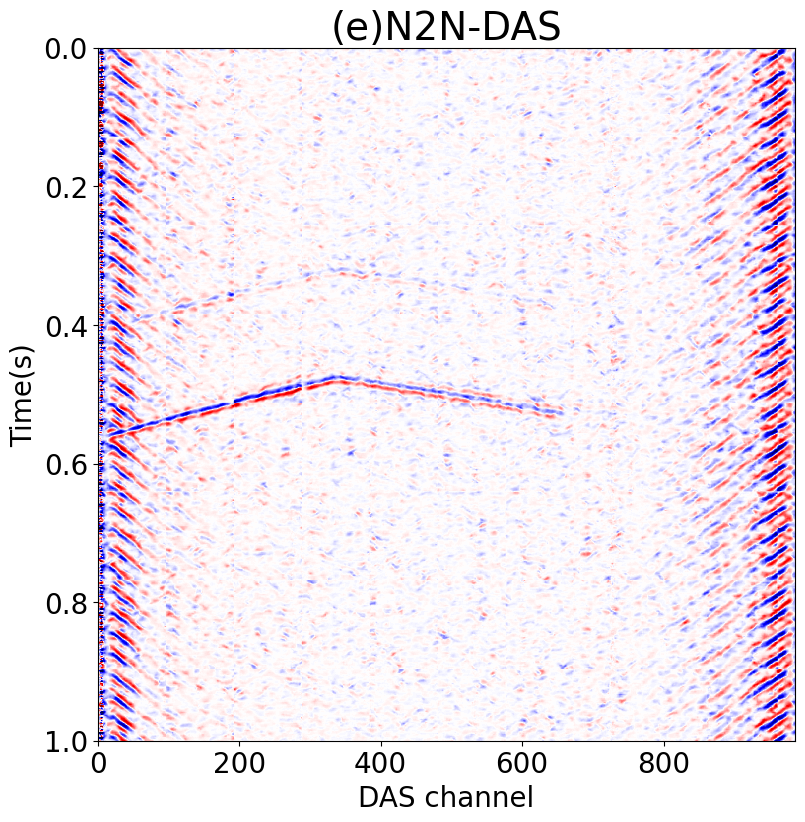

In [9]:
plt.rcParams["figure.figsize"] = (9,9)
plt.title('(e)N2N-DAS',fontsize=28)
plt.imshow(st_dasn2n[:1000,], vmin=-40, vmax=40, cmap="seismic", aspect="auto", extent=[0,len(st_raw),1,0])
plt.xlabel('DAS channel', fontsize=20)
plt.ylabel('Time(s)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot()

In [10]:
import scipy

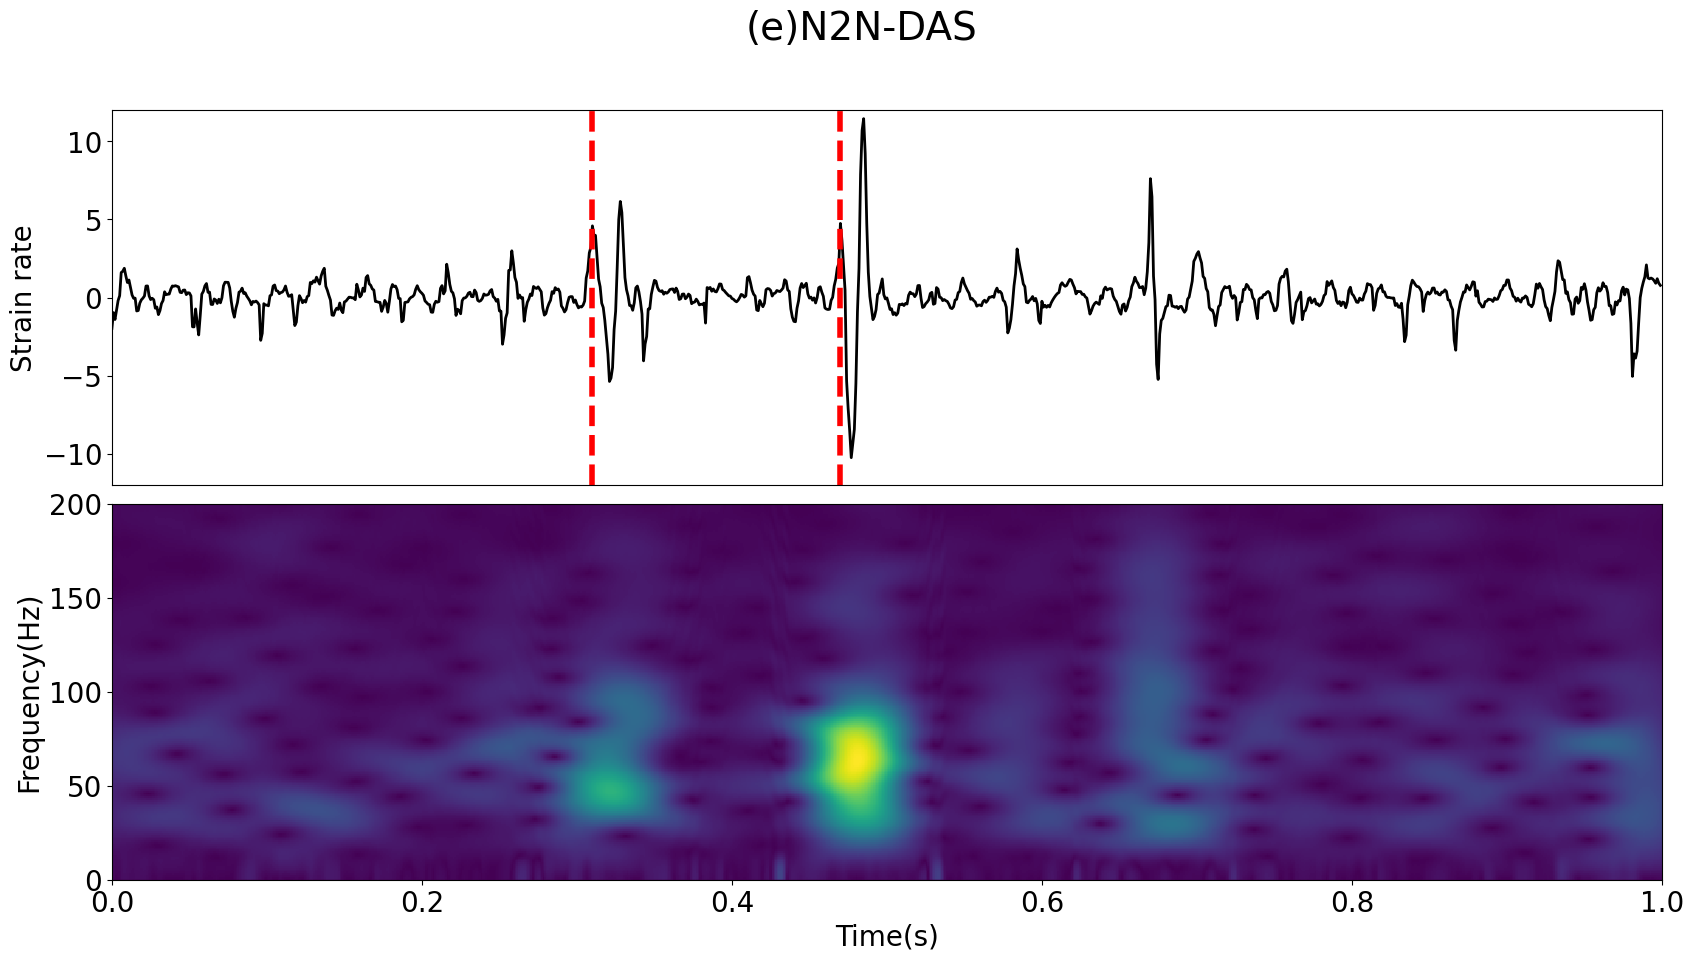

In [18]:
plt.rcParams["figure.figsize"] = (20,10) # Smaller fig size to make notebook size smaller

channel_no = 365
arrival1 = 310/1000 # Arrival time in sec
arrival2 = 470/1000 # Arrival time in sec

fig, axs = plt.subplots(2, gridspec_kw={'height_ratios': [1, 1]})
axs[0].plot(np.arange(0, 1000)/1000, st_dasn2n[:1000,channel_no], color='k', linewidth=2)
axs[0].axvline(x=arrival1, ls='--', color="red", linewidth=4)
axs[0].axvline(x=arrival2, ls='--', color="red", linewidth=4)
ylim = np.amax(abs(st_dasn2n[:1000,channel_no])) * 1.05
axs[0].set_ylim(-ylim, ylim)
axs[0].set_xlim(0, 1)
axs[0].tick_params(labelsize=20)
axs[0].set_ylabel("Strain rate", fontsize=20)
axs[0].axes.xaxis.set_visible(False)

f, t, Sxx = scipy.signal.spectrogram(np.pad(st_dasn2n[:1000,channel_no], (50,50), "constant"), fs=1000, window = scipy.signal.windows.hamming(101), noverlap=100, nfft=1024, scaling='spectrum')
axs[1].pcolormesh(t-0.05, f, Sxx**(1/2), cmap="viridis")
axs[1].set_ylim(0, 200)
axs[1].set_ylabel('Frequency(Hz)', fontsize=20)
axs[1].set_xlabel('Time(s)', fontsize =20)
axs[1].tick_params(labelsize=20)

fig.suptitle("(e)N2N-DAS", fontsize=28)

plt.subplots_adjust(wspace=0, hspace=0.05)

plt.show()